In [73]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import LeaveOneOut,GridSearchCV
from sklearn.linear_model import Ridge,ElasticNet
from sklearn.model_selection import train_test_split
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt

In [2]:
gmm_bin=pd.read_csv('Result/bin_cluster_GMM.csv',sep=';')
feature_extracted=pd.read_csv('Result/feature_extracted.csv',sep=';')

In [3]:
feat=list(range(0,512))
for i in feat:
    feat[i]='FEATURE_'+str(i).zfill(3)
feature=['GRID_SAT_JPG']+feat
feature_extracted.columns=feature
merged_data=gmm_bin[['IDKEC','GMM_bin','yj_mean_w','GRID_SAT_JPG']].merge(feature_extracted)

In [4]:
pov_district=pd.read_csv('Data/data_kab_pov.csv',sep=',',dtype={'IDKAB':object})

In [5]:
pov_district.head()

,IDKAB,ind_miskin,jlh_pend_2015,percent_miskin,NMKAB,percent_pov_2020,percent_pov_2016,percent_pov_2015
0,7101,55752,233189,23.908503,Bolaang Mongondow,7.27,8.34,8.63
1,7102,23797,329004,7.233043,Minahasa,7.30,8.36,8.80
2,7103,16662,129584,12.858069,Kepulauan Sangihe,11.14,12.28,12.27
3,7104,9245,88803,10.410684,Kepulauan Talaud,9.49,10.29,10.09
4,7105,59000,204983,28.782875,Minahasa Selatan,9.14,9.92,10.22


In [6]:
pov_district.query('percent_pov_2015==\'-\'')

,IDKAB,ind_miskin,jlh_pend_2015,percent_miskin,NMKAB,percent_pov_2020,percent_pov_2016,percent_pov_2015
64,7413,37131,77084,48.169529,Muna Barat,13.30,15.77,-
65,7414,32191,89279,36.056631,Buton Tengah,15.32,13.69,-
66,7415,29344,77548,37.839790,Buton Selatan,14.11,13.74,-


In [7]:
pov_2015=pov_district.query('percent_pov_2015!=\'-\'').copy()
pov_2015.percent_pov_2015=pov_2015.percent_pov_2015.astype(float)

In [9]:
merged_data['IDKAB']=merged_data.IDKEC.apply(lambda y:str(y)[:4])
merged_data_POV=merged_data.merge(pov_2015)

In [10]:
 X_train, X_test, y_train, y_test = train_test_split(merged_data_POV[['IDKAB']+feat], 
                                                     merged_data_POV[['IDKAB','percent_pov_2015']], 
                                                     test_size=0.2, random_state=42)

In [38]:
proper_train=X_train.merge(y_train,left_index=True, right_index=True)
proper_train=proper_train[['IDKAB_x','percent_pov_2015']+feat].groupby('IDKAB_x').agg('mean').reset_index()
proper_train_X=proper_train[feat]
proper_train_y=proper_train[['percent_pov_2015']]


In [39]:
proper_test=X_test.merge(y_test,left_index=True, right_index=True)
proper_test=proper_test[['IDKAB_y','percent_pov_2015']+feat].groupby('IDKAB_y').agg('mean').reset_index()
proper_test_X=proper_test[feat]
proper_test_y=proper_test[['percent_pov_2015']]


In [83]:
max_lambda = 10
print("maximum lambda: " + str(max_lambda))
min_lambda = 0.00001
print("minimum lambda: " +str(min_lambda))

parameters = {'alpha':  10**np.linspace(np.log10(min_lambda), np.log10(max_lambda),num=15)}

maximum lambda: 10
minimum lambda: 1e-05


In [84]:
cv=LeaveOneOut()
ridge = Ridge(fit_intercept = True, normalize = True,tol=1e-5,random_state=123)
ridge_regressor = GridSearchCV(ridge, parameters, scoring = "neg_mean_squared_error", cv = cv)

%time ridge_regressor.fit(proper_train_X,proper_train_y)

CPU times: user 2min 48s, sys: 2min 27s, total: 5min 15s
Wall time: 40.9 s


GridSearchCV(cv=LeaveOneOut(),
             estimator=Ridge(normalize=True, random_state=123, tol=1e-05),
             param_grid={'alpha': array([1.00000000e-05, 2.68269580e-05, 7.19685673e-05, 1.93069773e-04,
       5.17947468e-04, 1.38949549e-03, 3.72759372e-03, 1.00000000e-02,
       2.68269580e-02, 7.19685673e-02, 1.93069773e-01, 5.17947468e-01,
       1.38949549e+00, 3.72759372e+00, 1.00000000e+01])},
             scoring='neg_mean_squared_error')

In [85]:
print(ridge_regressor.best_params_)
best_ridge = ridge_regressor.best_estimator_
RMSE_valid = round(((proper_test_y - best_ridge.predict(proper_test_X))**2).mean()**0.5,4)

print("Validation RMSE: " + str(RMSE_valid))

{'alpha': 3.727593720314938}
Validation RMSE: percent_pov_2015    3.4684
dtype: float64


In [86]:
max_lambda = 10
min_lambda = 0.0001

max_l1=1
min_l1=0

parameters = {'alpha':10**np.linspace(np.log10(min_lambda), np.log10(max_lambda),num=15),
              'l1_ratio':np.linspace(min_l1,max_l1,num=15)}

In [87]:
enet = ElasticNet(fit_intercept = True, normalize = True,tol=1e-5,random_state=123)
enet_regressor = GridSearchCV(enet, parameters, scoring = "neg_mean_squared_error", cv = cv)

%time enet_regressor.fit(proper_train_X,proper_train_y)

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.98460283321254, tolerance: 0.016094091168831173
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.057096726758587, tolerance: 0.01610622651948052
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.715441094311178, tolerance: 0.01622598207792208
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.955754590667905, tolerance: 0.015926043246753247
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.19964256656215, tolerance: 0.016004925246753246
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.82471468505919, tolerance: 0.01599080116883117
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.839489936308613, tolerance: 0.015841800129870128
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.96861989270228, tolerance: 0.016090410519480524
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.175104119480963, tolerance: 0.01620284794805195
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.842380975269945, tolerance: 0.01591526288311688
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.518929120379404, tolerance: 0.015693766805194805
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.100071497187837, tolerance: 0.015932956805194808
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.348034097258623, tolerance: 0.015883866129870132
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.082751003198906, tolerance: 0.015791191220779224
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.932220148399118, tolerance: 0.016223341454545452
  model = cd_fast.enet_coordinate_descent(
/home/a

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.478926409741568, tolerance: 0.015966788701298702
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.065038142435363, tolerance: 0.016137744987012988
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.600486487787776, tolerance: 0.015600417792207789
  model = cd_fast.enet_coordinate_descent(
/home/a

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.821194130526345, tolerance: 0.015863557532467532
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.65778303627495, tolerance: 0.016164113818181818
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.03796107863006, tolerance: 0.01591526288311688
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.08142135047256, tolerance: 0.01620609394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.28552535917563, tolerance: 0.016053915246753245
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.440566029832773, tolerance: 0.015883866129870132
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.235040633374858, tolerance: 0.016225494987012985
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.301337102313555, tolerance: 0.016199027272727276
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.722502180897221, tolerance: 0.015966788701298702
  model = cd_fast.enet_coordinate_descent(
/home/a

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.348074579059597, tolerance: 0.01577241012987013
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.533617451154239, tolerance: 0.01583804794805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.273083189217894, tolerance: 0.01611355922077922
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.33838945338423, tolerance: 0.016097499246753248
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.123852237042103, tolerance: 0.015870792129870134
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.339665423030008, tolerance: 0.015876765246753247
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.433102268898981, tolerance: 0.016200654675324676
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.4060979233057, tolerance: 0.016198362129870126
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.297771706332181, tolerance: 0.016225494987012985
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.093528648530699, tolerance: 0.015173828311688313
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.094542151748696, tolerance: 0.015830099272727275
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.424728157169907, tolerance: 0.01577241012987013
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.336598063297641, tolerance: 0.016167718883116886
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.445765500992962, tolerance: 0.016097499246753248
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.102539854559817, tolerance: 0.015870792129870134
  model = cd_fast.enet_coordinate_descent(
/home/a

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.963448326587772, tolerance: 0.015772827168831167
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.49914947774885, tolerance: 0.016072038363636364
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.463675010199898, tolerance: 0.016200654675324676
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.3599906709396, tolerance: 0.01532490051948052
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.142205942900718, tolerance: 0.015299888857142863
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.149781532227728, tolerance: 0.015173828311688313
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.744605802618722, tolerance: 0.015924174675324677
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.76010406039951, tolerance: 0.01581256742857143
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.314160115282057, tolerance: 0.01607650142857143
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.22492996764603, tolerance: 0.01618053051948052
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.26390823224472, tolerance: 0.01607361394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.318055216800945, tolerance: 0.016013646675324678
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.364112627582921, tolerance: 0.016021632987012986
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.979794955291506, tolerance: 0.015778231220779218
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.264816891118192, tolerance: 0.01613491680519481
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.151809341912378, tolerance: 0.01593729924675325
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.766104972712471, tolerance: 0.015783602857142857
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.129887894174825, tolerance: 0.015934045454545458
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.286977884080484, tolerance: 0.016224463532467533
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.911600627002564, tolerance: 0.016024353792207797
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.279360533608726, tolerance: 0.016145523246753255
  model = cd_fast.enet_coordinate_descent(
/home/a

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.175314447008432, tolerance: 0.016093133428571427
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.130220061375667, tolerance: 0.016173864675324674
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.13817116217219, tolerance: 0.01611355922077922
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.485438846251169, tolerance: 0.016208649090909088
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.126224731830717, tolerance: 0.016091661948051946
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.716283753020884, tolerance: 0.016138936883116885
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.948350178910967, tolerance: 0.016148912857142858
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.147000783872485, tolerance: 0.016066459999999998
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.063032609791371, tolerance: 0.016136127714285717
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.990358977722472, tolerance: 0.016007755454545452
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.184707728515145, tolerance: 0.016039427272727277
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.136813845481884, tolerance: 0.016093133428571427
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.419016722163075, tolerance: 0.01616174194805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.604798509409529, tolerance: 0.016208649090909088
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.257800632614455, tolerance: 0.016091661948051946
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.861419475814163, tolerance: 0.016138341948051946
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.08068319496688, tolerance: 0.016148912857142858
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.27711388106259, tolerance: 0.016066459999999998
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.166387532811058, tolerance: 0.016221600129870128
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.372313804889755, tolerance: 0.016225008987012988
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.089270978349958, tolerance: 0.016007755454545452
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.184281899466905, tolerance: 0.016184721168831167
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.03644076496123, tolerance: 0.016054172077922074
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.533016492517403, tolerance: 0.01616174194805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.911675542434816, tolerance: 0.016056666129870133
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.28612110237394, tolerance: 0.01615168181818182
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.03425936281051, tolerance: 0.016138341948051946
  model = cd_fast.enet_coordinate_descent(
/home/achm_fi

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.08816867673875, tolerance: 0.01607572212987013
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.153394938703379, tolerance: 0.016165606883116884
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.232744484400506, tolerance: 0.016221600129870128
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.967331781866755, tolerance: 0.01622598207792208
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.32455786345149, tolerance: 0.016179233818181822
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.127270643759304, tolerance: 0.016184721168831167
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.137291586458258, tolerance: 0.01599080116883117
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.068522262062037, tolerance: 0.016221006675324674
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.94060493708211, tolerance: 0.016056666129870133
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.1670323952048784, tolerance: 0.016121512883116883
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.362837216278548, tolerance: 0.01607572212987013
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.110976252809272, tolerance: 0.016165606883116884
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.221999933913883, tolerance: 0.01610622651948052
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.080326326737048, tolerance: 0.01622598207792208
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.3753304622294715, tolerance: 0.016179233818181822
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.448010010806219, tolerance: 0.016004925246753246
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.347682617714067, tolerance: 0.01599080116883117
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.378292493200802, tolerance: 0.016221006675324674
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.425644327054224, tolerance: 0.016090410519480524
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.651592589675595, tolerance: 0.01620284794805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.374353910664886, tolerance: 0.016121512883116883
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.490612043030486, tolerance: 0.015693766805194805
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.526619855796411, tolerance: 0.015932956805194808
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.801278328958203, tolerance: 0.016094091168831173
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.690217011447147, tolerance: 0.016223341454545452
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.001134131241262, tolerance: 0.015926043246753247
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.328113955600414, tolerance: 0.016004925246753246
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.566462399047749, tolerance: 0.015600417792207789
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.188202229913253, tolerance: 0.015841800129870128
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.089741551653838, tolerance: 0.016090410519480524
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.9711699629403014, tolerance: 0.01591526288311688
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.484093468095754, tolerance: 0.015693766805194805
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.8308068550272365, tolerance: 0.015932956805194808
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.290226218742818, tolerance: 0.015791191220779224
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.9567149626846625, tolerance: 0.016223341454545452
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.274055164653486, tolerance: 0.015926043246753247
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.628759355497866, tolerance: 0.015600417792207789
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.555536864924524, tolerance: 0.015841800129870128
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.456542329322928, tolerance: 0.016090410519480524
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.46451987645218, tolerance: 0.01591526288311688
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.725467633251991, tolerance: 0.015693766805194805
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.944501993471508, tolerance: 0.015932956805194808
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.218912655114864, tolerance: 0.015883866129870132
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.4410657570621055, tolerance: 0.015791191220779224
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.326961968343828, tolerance: 0.016223341454545452
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.037197989060025, tolerance: 0.015966788701298702
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.436000840501449, tolerance: 0.016137744987012988
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.187584109607539, tolerance: 0.015600417792207789
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.8102225650756525, tolerance: 0.015863557532467532
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.650133235085401, tolerance: 0.016164113818181818
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.4008512786174405, tolerance: 0.01591526288311688
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.2739864660084, tolerance: 0.01620609394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.73848423886963, tolerance: 0.016053915246753245
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.03521409842958, tolerance: 0.015883866129870132
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.81074727131799, tolerance: 0.016199027272727276
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.200342661684175, tolerance: 0.015966788701298702
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.624356582836874, tolerance: 0.016137744987012988
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.2890457858326, tolerance: 0.01583804794805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.786770373730135, tolerance: 0.01611355922077922
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.94631448850008, tolerance: 0.015863557532467532
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.102437879540524, tolerance: 0.015876765246753247
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.069158740957004, tolerance: 0.01620609394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.47448417741745, tolerance: 0.016053915246753245
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.38804602340141, tolerance: 0.016225494987012985
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.553074944109635, tolerance: 0.016199027272727276
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.082042892226564, tolerance: 0.015966788701298702
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.594474789202184, tolerance: 0.01577241012987013
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.012602222480872, tolerance: 0.01583804794805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.462852973358146, tolerance: 0.01611355922077922
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.525682600484597, tolerance: 0.016097499246753248
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.890033304165925, tolerance: 0.015870792129870134
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.172339999867106, tolerance: 0.015876765246753247
  model = cd_fast.enet_coordinate_descent(
/home/a

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.566316760895845, tolerance: 0.016072038363636364
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.338349369321172, tolerance: 0.016200654675324676
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.51682769828492, tolerance: 0.016198362129870126
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.820099577031314, tolerance: 0.015173828311688313
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.79120761776554, tolerance: 0.015830099272727275
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.5134811656558, tolerance: 0.01577241012987013
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.677590306455354, tolerance: 0.016167718883116886
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.737655881443704, tolerance: 0.016097499246753248
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.10470039158097, tolerance: 0.015870792129870134
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.941019114427974, tolerance: 0.015772827168831167
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.731468633026488, tolerance: 0.016072038363636364
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.5368109995326, tolerance: 0.016200654675324676
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.556467540021384, tolerance: 0.01532490051948052
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.063980278738548, tolerance: 0.015299888857142863
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.014710195389313, tolerance: 0.015173828311688313
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.94468615706231, tolerance: 0.015924174675324677
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.354929768082677, tolerance: 0.01581256742857143
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.862332848490066, tolerance: 0.01607650142857143
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.789361193125718, tolerance: 0.01607361394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.769649180957344, tolerance: 0.016013646675324678
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.41586605581783, tolerance: 0.015772827168831167
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.697761369488205, tolerance: 0.01613491680519481
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.83820544477927, tolerance: 0.01532490051948052
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.24674399910526, tolerance: 0.015299888857142863
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.91891099041566, tolerance: 0.015934045454545458
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.262483599211937, tolerance: 0.015924174675324677
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.609808538500186, tolerance: 0.01581256742857143
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.530841766089367, tolerance: 0.01618053051948052
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.926292801771623, tolerance: 0.01607361394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.971057217421425, tolerance: 0.016013646675324678
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.37581618027987, tolerance: 0.015778231220779218
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.863661486930447, tolerance: 0.01613491680519481
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.999743363560427, tolerance: 0.01532490051948052
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.88689422012307, tolerance: 0.015934045454545458
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.14840294587326, tolerance: 0.015924174675324677
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.571825683528395, tolerance: 0.01581256742857143
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.63126831178861, tolerance: 0.01618053051948052
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.819357858605184, tolerance: 0.01607361394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.881463946878362, tolerance: 0.016013646675324678
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.442456245652075, tolerance: 0.015778231220779218
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.71798837443921, tolerance: 0.01613491680519481
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.8868580822692, tolerance: 0.01532490051948052
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.234507007905005, tolerance: 0.015934045454545458
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.495302912869242, tolerance: 0.015924174675324677
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.070019784890942, tolerance: 0.01581256742857143
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.120984834439376, tolerance: 0.01618053051948052
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.25978394197207, tolerance: 0.01607361394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.337678045908003, tolerance: 0.016013646675324678
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.932904494522965, tolerance: 0.015778231220779218
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.148660999709097, tolerance: 0.01613491680519481
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.220244825412014, tolerance: 0.01532490051948052
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.323941238830464, tolerance: 0.015934045454545458
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.025821079719076, tolerance: 0.015924174675324677
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.814150832119944, tolerance: 0.01581256742857143
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.56069984555898, tolerance: 0.01618053051948052
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.244328962872636, tolerance: 0.01607361394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.48902136055204, tolerance: 0.016013646675324678
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.431557478335215, tolerance: 0.016021632987012986
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.894226782859949, tolerance: 0.015778231220779218
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.22635579737141, tolerance: 0.01613491680519481
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.585933284580879, tolerance: 0.015783602857142857
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.537039814965315, tolerance: 0.015934045454545458
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.202671692808398, tolerance: 0.015924174675324677
  model = cd_fast.enet_coordinate_descent(
/home/a

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.655236489172946, tolerance: 0.016024353792207797
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.802908498766342, tolerance: 0.016145523246753255
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.168266984533904, tolerance: 0.01618053051948052
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.029534888700072, tolerance: 0.01611355922077922
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.119772126189304, tolerance: 0.016021632987012986
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.634963287621853, tolerance: 0.015778231220779218
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.840632694189935, tolerance: 0.01593729924675325
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.281494021416314, tolerance: 0.015783602857142857
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.114957647618102, tolerance: 0.015934045454545458
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.420148210661258, tolerance: 0.016224463532467533
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.82842412519307, tolerance: 0.016024353792207797
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.370421513118345, tolerance: 0.016145523246753255
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.266978469625672, tolerance: 0.016173864675324674
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.50754934096089, tolerance: 0.01611355922077922
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.69133140726632, tolerance: 0.016021632987012986
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.169400027350475, tolerance: 0.016138936883116885
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.217688127609625, tolerance: 0.01593729924675325
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.023809574294273, tolerance: 0.015783602857142857
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.921217159590864, tolerance: 0.016136127714285717
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.700244252916052, tolerance: 0.016224463532467533
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.496370938968518, tolerance: 0.016024353792207797
  model = cd_fast.enet_coordinate_descent(
/home/a

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.50459211906045, tolerance: 0.016039427272727277
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.95447287528553, tolerance: 0.016093133428571427
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.955149714049101, tolerance: 0.016173864675324674
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.7073551425624, tolerance: 0.01616174194805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.416953502448605, tolerance: 0.016208649090909088
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.711457829838428, tolerance: 0.016091661948051946
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.658117830786402, tolerance: 0.016138341948051946
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.014596133835798, tolerance: 0.016148912857142858
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.219397708857436, tolerance: 0.016066459999999998
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.392496459065988, tolerance: 0.016221600129870128
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.263348519959504, tolerance: 0.016225008987012988
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.224753394016135, tolerance: 0.016007755454545452
  model = cd_fast.enet_coordinate_descent(
/home/a

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.654395919511943, tolerance: 0.016184721168831167
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.938220108452967, tolerance: 0.016054172077922074
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.715379047868762, tolerance: 0.01616174194805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.3305747046097, tolerance: 0.01615168181818182
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.704194713292095, tolerance: 0.016138341948051946
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.143425684456293, tolerance: 0.016148912857142858
  model = cd_fast.enet_coordinate_descent(
/home/achm_fi

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.700492130277857, tolerance: 0.016221600129870128
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.435686756412263, tolerance: 0.016225008987012988
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.49858955549457, tolerance: 0.016007755454545452
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.182262221563994, tolerance: 0.016184721168831167
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.920198511948546, tolerance: 0.016054172077922074
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.24059889771968, tolerance: 0.01616174194805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.459257038908829, tolerance: 0.016056666129870133
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.537054994291344, tolerance: 0.01615168181818182
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.007308690303818, tolerance: 0.016138341948051946
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.349215218042033, tolerance: 0.016165606883116884
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.460761948470688, tolerance: 0.016221600129870128
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.072242693546068, tolerance: 0.016225008987012988
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.201060899340256, tolerance: 0.01622598207792208
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.19696426538754, tolerance: 0.016179233818181822
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.1909480349658, tolerance: 0.016184721168831167
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.47369208348134, tolerance: 0.01599080116883117
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.19951821318806, tolerance: 0.016221006675324674
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.4604001416227, tolerance: 0.016056666129870133
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.369326690832466, tolerance: 0.01620284794805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.11044509175954, tolerance: 0.016121512883116883
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.7691321418761, tolerance: 0.01607572212987013
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.72434079794766, tolerance: 0.015932956805194808
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.52745521453011, tolerance: 0.016094091168831173
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.17140475167479, tolerance: 0.01610622651948052
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.4976029179093, tolerance: 0.016223341454545452
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.490864727168756, tolerance: 0.015926043246753247
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52.9498914379997, tolerance: 0.016004925246753246
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52.193815993805025, tolerance: 0.015841800129870128
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.380355373208985, tolerance: 0.016090410519480524
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.7607446656199, tolerance: 0.01620284794805195
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.33540103186351, tolerance: 0.01591526288311688
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.97851157150607, tolerance: 0.015693766805194805
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.36663508846271, tolerance: 0.015932956805194808
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.858068372574074, tolerance: 0.015883866129870132
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.54492055282452, tolerance: 0.015791191220779224
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.2906412513087, tolerance: 0.016223341454545452
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.78313761928152, tolerance: 0.016137744987012988
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.24929865181738, tolerance: 0.015600417792207789
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.78533542103366, tolerance: 0.015841800129870128
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.397924378936494, tolerance: 0.015863557532467532
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.19230091254782, tolerance: 0.016164113818181818
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.2121958429904, tolerance: 0.01591526288311688
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.53419871086577, tolerance: 0.01620609394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.20385478051978, tolerance: 0.016053915246753245
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.98852885086103, tolerance: 0.015883866129870132
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.188082275663305, tolerance: 0.016225494987012985
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.97835767947431, tolerance: 0.016199027272727276
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.11837041184429, tolerance: 0.015966788701298702
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.163405300281326, tolerance: 0.01577241012987013
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.69747432987923, tolerance: 0.01583804794805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.750183642408885, tolerance: 0.01611355922077922
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.57235492702766, tolerance: 0.016097499246753248
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.02993440655015, tolerance: 0.015870792129870134
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.33063708556153, tolerance: 0.015876765246753247
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.75977016407106, tolerance: 0.016200654675324676
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.14468896560159, tolerance: 0.016198362129870126
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.18755296749569, tolerance: 0.016225494987012985
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.975657848233375, tolerance: 0.015173828311688313
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.572767899216245, tolerance: 0.015830099272727275
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.79878610123878, tolerance: 0.01577241012987013
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.02264134584524, tolerance: 0.016167718883116886
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.7030991933923, tolerance: 0.016097499246753248
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.220914637429345, tolerance: 0.015870792129870134
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.03698954740841, tolerance: 0.015772827168831167
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.73846400900159, tolerance: 0.016072038363636364
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.119888601337095, tolerance: 0.016200654675324676
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.400076540561756, tolerance: 0.015299888857142863
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.16724172415377, tolerance: 0.015173828311688313
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.246214402616154, tolerance: 0.015830099272727275
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.33423914280028, tolerance: 0.01581256742857143
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.2232259859332, tolerance: 0.01607650142857143
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.771671966883147, tolerance: 0.016167718883116886
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.88703723201508, tolerance: 0.01607361394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.8648902642113, tolerance: 0.016013646675324678
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.303435325236716, tolerance: 0.015772827168831167
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.331230963589135, tolerance: 0.015778231220779218
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.97069546894218, tolerance: 0.01613491680519481
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.89794709798206, tolerance: 0.01532490051948052
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.95355138834714, tolerance: 0.015934045454545458
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.82512801371753, tolerance: 0.015924174675324677
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.6483222524041, tolerance: 0.01581256742857143
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.52559774313368, tolerance: 0.016145523246753255
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.606039468485818, tolerance: 0.01618053051948052
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.6579700611913, tolerance: 0.01607361394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.065291189441965, tolerance: 0.01611355922077922
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.45915589123909, tolerance: 0.016021632987012986
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.783886263290363, tolerance: 0.015778231220779218
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.135673750270207, tolerance: 0.016138936883116885
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.41371012637864, tolerance: 0.01593729924675325
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.505813611470124, tolerance: 0.015783602857142857
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.1187879470488, tolerance: 0.016136127714285717
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.431440406165017, tolerance: 0.016224463532467533
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.274365240601867, tolerance: 0.016024353792207797
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.20481584275172, tolerance: 0.016039427272727277
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.621577065966157, tolerance: 0.016093133428571427
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.848021584081618, tolerance: 0.016173864675324674
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.167333775012303, tolerance: 0.016208649090909088
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.75700474552668, tolerance: 0.016091661948051946
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.282930385257774, tolerance: 0.016138936883116885
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.251673572711567, tolerance: 0.016066459999999998
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.876792042435582, tolerance: 0.016136127714285717
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.63866194331876, tolerance: 0.016224463532467533
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.703802334748914, tolerance: 0.016039427272727277
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.588670891293688, tolerance: 0.016093133428571427
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.213918662325316, tolerance: 0.016173864675324674
  model = cd_fast.enet_coordinate_descent(
/home/a

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.42161699425533, tolerance: 0.016208649090909088
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.727257009965555, tolerance: 0.016091661948051946
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.4419950668194, tolerance: 0.016138936883116885
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.06317251873395, tolerance: 0.016066459999999998
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.68491180114811, tolerance: 0.016136127714285717
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.820652131639967, tolerance: 0.016224463532467533
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.06792572056508, tolerance: 0.016039427272727277
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.554129140797215, tolerance: 0.016093133428571427
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.66424358159455, tolerance: 0.016173864675324674
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.79666269019403, tolerance: 0.016208649090909088
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.763843114236934, tolerance: 0.016091661948051946
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.499993439531675, tolerance: 0.016138936883116885
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.83588683962276, tolerance: 0.016066459999999998
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.175878570671077, tolerance: 0.016136127714285717
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.633319654058454, tolerance: 0.016224463532467533
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.59772745296203, tolerance: 0.016039427272727277
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.149885748739393, tolerance: 0.016093133428571427
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.01532604554481, tolerance: 0.016173864675324674
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.170397635533206, tolerance: 0.016208649090909088
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.34705553267772, tolerance: 0.016091661948051946
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.708409659434691, tolerance: 0.016138936883116885
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.55548967373784, tolerance: 0.016066459999999998
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.981968104689237, tolerance: 0.016136127714285717
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.464760514069425, tolerance: 0.016224463532467533
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.045376763791225, tolerance: 0.016039427272727277
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.205344837345784, tolerance: 0.016093133428571427
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.80631066745142, tolerance: 0.016173864675324674
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.00488160302309, tolerance: 0.016208649090909088
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.13094464545556, tolerance: 0.016091661948051946
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.096235538873245, tolerance: 0.016138936883116885
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.515086808322607, tolerance: 0.016066459999999998
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.671375953739373, tolerance: 0.016136127714285717
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.035921697413873, tolerance: 0.016224463532467533
  model = cd_fast.enet_coordinate_descent(
/home/a

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.7156848226168, tolerance: 0.016039427272727277
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.040959885605641, tolerance: 0.016093133428571427
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.633169449024301, tolerance: 0.016173864675324674
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.3211502784398, tolerance: 0.016208649090909088
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.3201196415048, tolerance: 0.016091661948051946
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.447000239270668, tolerance: 0.016138936883116885
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.446948396621542, tolerance: 0.016066459999999998
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.078625827099842, tolerance: 0.016136127714285717
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.83216421531517, tolerance: 0.016224463532467533
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.325009429267977, tolerance: 0.016039427272727277
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.1017143505692, tolerance: 0.016093133428571427
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.346433622709604, tolerance: 0.016173864675324674
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104.62308658677742, tolerance: 0.016208649090909088
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108.26818441239271, tolerance: 0.016091661948051946
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107.24095414104127, tolerance: 0.016138936883116885
  model = cd_fast.enet_coordinate_descent(
/home/a

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106.90047881567375, tolerance: 0.016066459999999998
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108.14715839217996, tolerance: 0.016136127714285717
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 107.91833555727055, tolerance: 0.016224463532467533
  model = cd_fast.enet_coordinate_descent(
/home/a

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108.21186646859348, tolerance: 0.016039427272727277
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108.24418246887609, tolerance: 0.016093133428571427
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101.96045496108309, tolerance: 0.016173864675324674
  model = cd_fast.enet_coordinate_descent(
/home/a

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83.38924351826046, tolerance: 0.016208649090909088
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84.68057199092026, tolerance: 0.016091661948051946
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86.49867707194682, tolerance: 0.016138936883116885
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85.8460770739841, tolerance: 0.016066459999999998
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85.77307090985911, tolerance: 0.016136127714285717
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86.47695655821374, tolerance: 0.016224463532467533
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85.6624683225798, tolerance: 0.016039427272727277
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 86.66161570470669, tolerance: 0.016093133428571427
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83.49297496074591, tolerance: 0.016173864675324674
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.516810309578396, tolerance: 0.016208649090909088
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.30858655110316, tolerance: 0.016091661948051946
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.53378271030803, tolerance: 0.016138936883116885
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64.95582163859913, tolerance: 0.016148912857142858
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.07204368146296, tolerance: 0.016066459999999998
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.01036706136594, tolerance: 0.016136127714285717
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67.33855426029183, tolerance: 0.016007755454545452
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68.98345402086568, tolerance: 0.016039427272727277
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.14173711070863, tolerance: 0.016093133428571427
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.66396698434437, tolerance: 0.016054172077922074
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.35105527311947, tolerance: 0.01616174194805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52.23655502318801, tolerance: 0.016208649090909088
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.52548497359814, tolerance: 0.016138341948051946
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.438886193304675, tolerance: 0.016148912857142858
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.087030148089404, tolerance: 0.016066459999999998
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.89436046047889, tolerance: 0.016225008987012988
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.5079573986128, tolerance: 0.016007755454545452
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.03310288540544, tolerance: 0.016039427272727277
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.78287015243637, tolerance: 0.016184721168831167
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.24165451403131, tolerance: 0.016054172077922074
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.477336341123525, tolerance: 0.01616174194805195
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.35499388962768, tolerance: 0.01615168181818182
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.298416675907816, tolerance: 0.016138341948051946
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.36795314465029, tolerance: 0.016148912857142858
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50.983496729869, tolerance: 0.016221600129870128
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.24434019361189, tolerance: 0.016225008987012988
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47.80837865579032, tolerance: 0.016007755454545452
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.77664331868648, tolerance: 0.016179233818181822
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.38434831568692, tolerance: 0.016184721168831167
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.91861808448161, tolerance: 0.016054172077922074
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.84344765806031, tolerance: 0.016056666129870133
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.591291027868095, tolerance: 0.01615168181818182
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.97249423281705, tolerance: 0.016138341948051946
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.46215811416451, tolerance: 0.016165606883116884
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.49058764462407, tolerance: 0.016221600129870128
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.86882067254953, tolerance: 0.016225008987012988
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.16686749283862, tolerance: 0.016179233818181822
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.66129356140101, tolerance: 0.016184721168831167
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.528582578576966, tolerance: 0.016054172077922074
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.45039787222548, tolerance: 0.016056666129870133
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.44532707727758, tolerance: 0.01615168181818182
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.84410556905465, tolerance: 0.016138341948051946
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.77414080972232, tolerance: 0.016165606883116884
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.59142093668055, tolerance: 0.016221600129870128
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.937104714562714, tolerance: 0.016225008987012988
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.16550927422028, tolerance: 0.016179233818181822
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.67621148770531, tolerance: 0.016184721168831167
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.3017764917698, tolerance: 0.016054172077922074
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.175023135897312, tolerance: 0.016056666129870133
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.64527668379822, tolerance: 0.01615168181818182
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.270874729377, tolerance: 0.016138341948051946
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.17868185211072, tolerance: 0.01607572212987013
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.056780526135256, tolerance: 0.016165606883116884
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.36749737385246, tolerance: 0.016221600129870128
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.19832425824019, tolerance: 0.01622598207792208
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.94043463415422, tolerance: 0.016179233818181822
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.03929745781357, tolerance: 0.016184721168831167
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.7631737087832, tolerance: 0.016221006675324674
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.41870258090548, tolerance: 0.016056666129870133
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.97370458279768, tolerance: 0.01615168181818182
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.92803689608926, tolerance: 0.01607572212987013
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.950903038455543, tolerance: 0.016165606883116884
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.67187930029166, tolerance: 0.016221600129870128
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.647080058736243, tolerance: 0.01622598207792208
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.461886597850025, tolerance: 0.016179233818181822
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.538876214423333, tolerance: 0.016184721168831167
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.52366142389242, tolerance: 0.01599080116883117
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.788216366507207, tolerance: 0.016221006675324674
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.286644995883286, tolerance: 0.016056666129870133
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.742680878618323, tolerance: 0.01620284794805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.50105559347786, tolerance: 0.016121512883116883
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.77552535460911, tolerance: 0.01607572212987013
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.184494815293142, tolerance: 0.016094091168831173
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.330547303477807, tolerance: 0.01610622651948052
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.676545403749877, tolerance: 0.01622598207792208
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.867626262826096, tolerance: 0.016004925246753246
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.83220267564779, tolerance: 0.01599080116883117
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.61578651764073, tolerance: 0.016221006675324674
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.699580866721224, tolerance: 0.016090410519480524
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.090144716055477, tolerance: 0.01620284794805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.922095923467207, tolerance: 0.016121512883116883
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.404619621251886, tolerance: 0.015693766805194805
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.749749469450677, tolerance: 0.015932956805194808
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.623782580219114, tolerance: 0.016094091168831173
  model = cd_fast.enet_coordinate_descent(
/home/a

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.146597310306714, tolerance: 0.015791191220779224
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.278344020977734, tolerance: 0.016223341454545452
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.99385620554218, tolerance: 0.015926043246753247
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.206165020895007, tolerance: 0.015600417792207789
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.212027411020927, tolerance: 0.015841800129870128
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.40976823984526, tolerance: 0.016090410519480524
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.38281746849123, tolerance: 0.01591526288311688
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.051125910392088, tolerance: 0.015693766805194805
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.738365799830028, tolerance: 0.015932956805194808
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.464367003760533, tolerance: 0.015883866129870132
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.834343860115304, tolerance: 0.015791191220779224
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.066006140101436, tolerance: 0.016223341454545452
  model = cd_fast.enet_coordinate_descent(
/home/a

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.887719593002394, tolerance: 0.015966788701298702
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.400648058738952, tolerance: 0.016137744987012988
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.01477987841826, tolerance: 0.015600417792207789
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.7030659100348, tolerance: 0.015863557532467532
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.5096817742189, tolerance: 0.016164113818181818
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.488668704512648, tolerance: 0.01591526288311688
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.337792307534404, tolerance: 0.01620609394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.561506890380041, tolerance: 0.016053915246753245
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.129894850075775, tolerance: 0.015883866129870132
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.039366530492664, tolerance: 0.016199027272727276
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.972256732887029, tolerance: 0.015966788701298702
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.632084288552942, tolerance: 0.016137744987012988
  model = cd_fast.enet_coordinate_descent(
/home/a

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.433802127858755, tolerance: 0.01583804794805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.786766530271393, tolerance: 0.01611355922077922
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.86894233755011, tolerance: 0.015863557532467532
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.890895155963253, tolerance: 0.015876765246753247
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.096145446107771, tolerance: 0.01620609394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.71317630614748, tolerance: 0.016053915246753245
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.021000943027904, tolerance: 0.016198362129870126
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.762233140266684, tolerance: 0.016225494987012985
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.69468062529672, tolerance: 0.016199027272727276
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.020823366527136, tolerance: 0.015830099272727275
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.539504406056246, tolerance: 0.01577241012987013
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.930781881061154, tolerance: 0.01583804794805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 165.13969709547854, tolerance: 0.016097499246753248
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166.94442699929198, tolerance: 0.015870792129870134
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 156.5631243547964, tolerance: 0.015876765246753247
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169.39107298987153, tolerance: 0.016072038363636364
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169.42005243807247, tolerance: 0.016200654675324676
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169.15025744114809, tolerance: 0.016198362129870126
  model = cd_fast.enet_coordinate_descent(
/home/a

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 165.362535294751, tolerance: 0.015173828311688313
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 162.8082222741473, tolerance: 0.015830099272727275
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169.07327961511967, tolerance: 0.01577241012987013
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104.29732810353723, tolerance: 0.01607650142857143
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99.32877105923289, tolerance: 0.016167718883116886
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104.05084051347563, tolerance: 0.016097499246753248
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101.94261007159415, tolerance: 0.016013646675324678
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 106.26574080638163, tolerance: 0.015772827168831167
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103.74652040234359, tolerance: 0.016072038363636364
  model = cd_fast.enet_coordinate_descent(
/home/a

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104.36034952526407, tolerance: 0.01613491680519481
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103.59896904507765, tolerance: 0.01532490051948052
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105.33658318928428, tolerance: 0.015299888857142863
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73.41064454503497, tolerance: 0.015934045454545458
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.5143436713873, tolerance: 0.015924174675324677
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.8081034520725, tolerance: 0.01581256742857143
  model = cd_fast.enet_coordinate_descent(
/home/achm_fi

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72.05830868268106, tolerance: 0.016145523246753255
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70.61070434300373, tolerance: 0.01618053051948052
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73.3619532940446, tolerance: 0.01607361394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_fi

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70.31017861528738, tolerance: 0.01611355922077922
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75.04888341833882, tolerance: 0.016021632987012986
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 72.45136635347764, tolerance: 0.015778231220779218
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.877959179626174, tolerance: 0.01593729924675325
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.31020268091305, tolerance: 0.015783602857142857
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.032695975377464, tolerance: 0.015934045454545458
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.34627089925458, tolerance: 0.016224463532467533
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.92447337005737, tolerance: 0.016024353792207797
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.06902592356073, tolerance: 0.016145523246753255
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.32775136818434, tolerance: 0.016093133428571427
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.7157190595061, tolerance: 0.016173864675324674
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.63115375319015, tolerance: 0.01611355922077922
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.844939169832756, tolerance: 0.016208649090909088
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.76965053155753, tolerance: 0.016091661948051946
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.7933578998811, tolerance: 0.016138936883116885
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.241982550541465, tolerance: 0.016066459999999998
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.47072866219388, tolerance: 0.016136127714285717
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.97886304730042, tolerance: 0.016224463532467533
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.69756725378244, tolerance: 0.016007755454545452
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.27365610499878, tolerance: 0.016039427272727277
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.438628066511896, tolerance: 0.016093133428571427
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.19458905720026, tolerance: 0.01616174194805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.16625463105055, tolerance: 0.016208649090909088
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.2812482120472, tolerance: 0.016091661948051946
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.983988353821132, tolerance: 0.016138341948051946
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.924336674421596, tolerance: 0.016148912857142858
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.706848478266465, tolerance: 0.016066459999999998
  model = cd_fast.enet_coordinate_descent(
/home/a

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.083578393048896, tolerance: 0.016221600129870128
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.057929432156556, tolerance: 0.016225008987012988
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.08311414159914, tolerance: 0.016007755454545452
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.325949345910544, tolerance: 0.016179233818181822
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.721372959157065, tolerance: 0.016184721168831167
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.566924798062544, tolerance: 0.016054172077922074
  model = cd_fast.enet_coordinate_descent(
/home/a

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.882509587009693, tolerance: 0.016056666129870133
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.011962110402337, tolerance: 0.01615168181818182
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.892948389160495, tolerance: 0.016138341948051946
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.394721997981804, tolerance: 0.016165606883116884
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.915781006505227, tolerance: 0.016221600129870128
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.084593969845443, tolerance: 0.016225008987012988
  model = cd_fast.enet_coordinate_descent(
/home/a

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.48232544204282, tolerance: 0.01622598207792208
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.378013790952252, tolerance: 0.016179233818181822
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.32869373603488, tolerance: 0.016184721168831167
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.22481610414627, tolerance: 0.016221006675324674
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.369076746464714, tolerance: 0.016056666129870133
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.8033739843833, tolerance: 0.01615168181818182
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.789966572767526, tolerance: 0.01607572212987013
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.16972418258584, tolerance: 0.016165606883116884
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.9520908635954, tolerance: 0.016221600129870128
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.739605859064326, tolerance: 0.01622598207792208
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.247084973749566, tolerance: 0.016179233818181822
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.03868198430166, tolerance: 0.016184721168831167
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.331635383924393, tolerance: 0.016221006675324674
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.950376829316966, tolerance: 0.016056666129870133
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.594675099300858, tolerance: 0.01615168181818182
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.372318785386568, tolerance: 0.01607572212987013
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.052515741742454, tolerance: 0.016165606883116884
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.25462969770787, tolerance: 0.016221600129870128
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.292224223605444, tolerance: 0.01622598207792208
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.994085248230917, tolerance: 0.016179233818181822
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.323342246869274, tolerance: 0.016184721168831167
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.009605121279577, tolerance: 0.016221006675324674
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.42388814534918, tolerance: 0.016056666129870133
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.065067280015583, tolerance: 0.01615168181818182
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.640443011708996, tolerance: 0.01607572212987013
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.294571121548827, tolerance: 0.016165606883116884
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.09757212262575, tolerance: 0.016221600129870128
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.702198481692577, tolerance: 0.01622598207792208
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.36916975443124, tolerance: 0.016179233818181822
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.071233715717995, tolerance: 0.016184721168831167
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.996224312404337, tolerance: 0.016221006675324674
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.59071911601322, tolerance: 0.016056666129870133
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.63703404906036, tolerance: 0.01615168181818182
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.148720028943558, tolerance: 0.01607572212987013
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.364156867413982, tolerance: 0.016165606883116884
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.514501367310856, tolerance: 0.016221600129870128
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.049936999049052, tolerance: 0.01622598207792208
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.0688453401024, tolerance: 0.016179233818181822
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.88624417950048, tolerance: 0.016184721168831167
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.65452893038487, tolerance: 0.016221006675324674
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.661911120855734, tolerance: 0.016056666129870133
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.827049001048053, tolerance: 0.01615168181818182
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.08640982925192, tolerance: 0.01607572212987013
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.430019171053203, tolerance: 0.016165606883116884
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.595114523518788, tolerance: 0.016221600129870128
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.01244219750393, tolerance: 0.01622598207792208
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.386051966226049, tolerance: 0.016179233818181822
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.31583949977201, tolerance: 0.016184721168831167
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.569902199733633, tolerance: 0.016221006675324674
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.628147095366856, tolerance: 0.016056666129870133
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.332189266848914, tolerance: 0.01615168181818182
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.909546212996375, tolerance: 0.01607572212987013
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.591005646235189, tolerance: 0.016165606883116884
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.089101189719429, tolerance: 0.016221600129870128
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.759087386711002, tolerance: 0.01622598207792208
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.796027914916451, tolerance: 0.016179233818181822
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.943063847467542, tolerance: 0.016184721168831167
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.145206022370836, tolerance: 0.016221006675324674
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7744283453167213, tolerance: 0.016056666129870133
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.24903293702743, tolerance: 0.01615168181818182
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.371979226315155, tolerance: 0.01607572212987013
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.402212797413426, tolerance: 0.016165606883116884
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.005238553387827, tolerance: 0.016221600129870128
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.85880910331953, tolerance: 0.01622598207792208
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.835342833806209, tolerance: 0.016179233818181822
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.131228430407532, tolerance: 0.016184721168831167
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.7612186882216605, tolerance: 0.016221006675324674
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.492775842961052, tolerance: 0.016056666129870133
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2589245554036594, tolerance: 0.01615168181818182
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.238672531053304, tolerance: 0.01607572212987013
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.421287967849253, tolerance: 0.016165606883116884
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.82956979153586, tolerance: 0.016221600129870128
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 240.97698648533046, tolerance: 0.01622598207792208
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 238.88468462876176, tolerance: 0.016179233818181822
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 240.43231166046726, tolerance: 0.016184721168831167
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 241.88756926835217, tolerance: 0.016221006675324674
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 239.52338251420952, tolerance: 0.016056666129870133
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 241.11527272601938, tolerance: 0.01615168181818182
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 241.7730410277589, tolerance: 0.01607572212987013
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 241.34565189705884, tolerance: 0.016165606883116884
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 241.82878417913588, tolerance: 0.016221600129870128
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144.7506882076064, tolerance: 0.01622598207792208
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 142.36245718557552, tolerance: 0.016179233818181822
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 142.06592302719872, tolerance: 0.016184721168831167
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 146.10940706036786, tolerance: 0.016221006675324674
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 143.53534014016358, tolerance: 0.016056666129870133
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 147.08127619237914, tolerance: 0.01615168181818182
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 146.54145346361605, tolerance: 0.016121512883116883
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 146.7702130570824, tolerance: 0.01607572212987013
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145.78191947597097, tolerance: 0.016165606883116884
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79.71035020816375, tolerance: 0.016094091168831173
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91.97529572931236, tolerance: 0.01610622651948052
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.41457150444111, tolerance: 0.01622598207792208
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 87.96439879858185, tolerance: 0.016004925246753246
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.08189896523507, tolerance: 0.01599080116883117
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 97.83549412151478, tolerance: 0.016221006675324674
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.2853544101539, tolerance: 0.016090410519480524
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96.12789436577842, tolerance: 0.01620284794805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98.1792137105298, tolerance: 0.016121512883116883
  model = cd_fast.enet_coordinate_descent(
/home/achm_fi

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.91593728512319, tolerance: 0.015932956805194808
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.912353586902896, tolerance: 0.016094091168831173
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.60501347286535, tolerance: 0.01610622651948052
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.09846899919397, tolerance: 0.016223341454545452
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60.05914533575958, tolerance: 0.015926043246753247
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.09852536726629, tolerance: 0.016004925246753246
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.64268557001782, tolerance: 0.015841800129870128
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.85237048514502, tolerance: 0.016090410519480524
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.397572074295994, tolerance: 0.01620284794805195
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77.52335998141818, tolerance: 0.015693766805194805
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 63.26056017211354, tolerance: 0.015932956805194808
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.056419300607956, tolerance: 0.016094091168831173
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.90271751889654, tolerance: 0.016223341454545452
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.6829485156598, tolerance: 0.015926043246753247
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.44376198771843, tolerance: 0.016004925246753246
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.702941789156085, tolerance: 0.015841800129870128
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.84827288779306, tolerance: 0.016090410519480524
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.35259998230052, tolerance: 0.01620284794805195
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58.89389624503839, tolerance: 0.015693766805194805
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.88462550215564, tolerance: 0.015932956805194808
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.252239814604508, tolerance: 0.016094091168831173
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.553401606406112, tolerance: 0.016223341454545452
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34.06888602399704, tolerance: 0.015926043246753247
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.71450991284422, tolerance: 0.016004925246753246
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.82530781261633, tolerance: 0.015841800129870128
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36.142141454284825, tolerance: 0.016090410519480524
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.35537523281536, tolerance: 0.01620284794805195
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.3191788838879, tolerance: 0.01591526288311688
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42.91944247448882, tolerance: 0.015693766805194805
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.463468005744687, tolerance: 0.015932956805194808
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.97744436718034, tolerance: 0.015883866129870132
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.07664633272151, tolerance: 0.015791191220779224
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.403005867945268, tolerance: 0.016223341454545452
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.21579959528694, tolerance: 0.016137744987012988
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.693046185248875, tolerance: 0.015600417792207789
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.962032884064655, tolerance: 0.015841800129870128
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.28494233093039, tolerance: 0.016164113818181818
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.376007586660364, tolerance: 0.01591526288311688
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.09118172027499, tolerance: 0.015693766805194805
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.05037384332664, tolerance: 0.015883866129870132
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.651488939313765, tolerance: 0.015791191220779224
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.504637315950333, tolerance: 0.016223341454545452
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.721679133776632, tolerance: 0.015966788701298702
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.06425520170791, tolerance: 0.016137744987012988
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.87723426776364, tolerance: 0.015600417792207789
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.582980439173383, tolerance: 0.015863557532467532
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.76294621020969, tolerance: 0.016164113818181818
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.613735461011913, tolerance: 0.01591526288311688
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.135111479854828, tolerance: 0.016053915246753245
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.91229208586509, tolerance: 0.015883866129870132
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.02414617683462, tolerance: 0.015791191220779224
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.686618492266604, tolerance: 0.015966788701298702
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.188286299513607, tolerance: 0.016137744987012988
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.60898990331495, tolerance: 0.015600417792207789
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20.187312980755763, tolerance: 0.015863557532467532
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.468343780515966, tolerance: 0.016164113818181818
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.60933025908659, tolerance: 0.01591526288311688
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.657668631364345, tolerance: 0.01620609394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.44955248148284, tolerance: 0.016053915246753245
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.243716408723998, tolerance: 0.015883866129870132
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.732234765269112, tolerance: 0.016199027272727276
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.88701015276061, tolerance: 0.015966788701298702
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.265200163064605, tolerance: 0.016137744987012988
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.638400382158892, tolerance: 0.01611355922077922
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.87497331733519, tolerance: 0.015863557532467532
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.610035954802356, tolerance: 0.016164113818181818
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.643715783705602, tolerance: 0.01620609394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.422662766985184, tolerance: 0.016053915246753245
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.042219248558212, tolerance: 0.015883866129870132
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.266986756074516, tolerance: 0.016199027272727276
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.106173527962028, tolerance: 0.015966788701298702
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.008748940884061, tolerance: 0.016137744987012988
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.600875651280887, tolerance: 0.01611355922077922
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.028790695972589, tolerance: 0.015863557532467532
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.358517658218091, tolerance: 0.016164113818181818
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.57594548922242, tolerance: 0.01620609394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.223931533633305, tolerance: 0.016053915246753245
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7955909390062175, tolerance: 0.015883866129870132
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.93749908122831, tolerance: 0.016199027272727276
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.112200464692933, tolerance: 0.015966788701298702
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.241615343319012, tolerance: 0.016137744987012988
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.944840662969568, tolerance: 0.01611355922077922
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.11353858736635, tolerance: 0.015863557532467532
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.30069218128989, tolerance: 0.016164113818181818
  model = cd_fast.enet_coordinate_descent(
/home/achm_fi

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.381233214934298, tolerance: 0.01620609394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.5463480620871906, tolerance: 0.016053915246753245
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.927015954517401, tolerance: 0.015883866129870132
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.053626120764193, tolerance: 0.016199027272727276
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.515450379883191, tolerance: 0.015966788701298702
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.394978881611564, tolerance: 0.016137744987012988
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.63230627271443, tolerance: 0.01611355922077922
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.252799319628309, tolerance: 0.015863557532467532
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.301062352608341, tolerance: 0.016164113818181818
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.767293213345198, tolerance: 0.01620609394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.106693331366756, tolerance: 0.016053915246753245
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5426687978113591, tolerance: 0.015883866129870132
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.737784178907873, tolerance: 0.016199027272727276
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8689616072356898, tolerance: 0.015966788701298702
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9780614817672415, tolerance: 0.016137744987012988
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5511672502022122, tolerance: 0.01611355922077922
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8432415085847822, tolerance: 0.015863557532467532
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7081900746501617, tolerance: 0.016164113818181818
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.39905461290669564, tolerance: 0.016053915246753245
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.321700306717986, tolerance: 0.015883866129870132
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1718458097267046, tolerance: 0.015791191220779224
  model = cd_fast.enet_coordinate_descent(
/home/a

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6426607140258511, tolerance: 0.015841800129870128
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9085061236743002, tolerance: 0.016090410519480524
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1315898260407664, tolerance: 0.01620284794805195
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.300016110301101, tolerance: 0.015693766805194805
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.28737227842145785, tolerance: 0.015932956805194808
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 309.12445122324635, tolerance: 0.016094091168831173
  model = cd_fast.enet_coordinate_descent(
/home/a

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 300.9654103722963, tolerance: 0.015791191220779224
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 316.62485522100957, tolerance: 0.016223341454545452
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 317.7137762851285, tolerance: 0.015926043246753247
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 317.47032140170785, tolerance: 0.016137744987012988
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 316.23100675185333, tolerance: 0.015600417792207789
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 316.6410976330703, tolerance: 0.015841800129870128
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 307.934722004164, tolerance: 0.015863557532467532
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 319.44120047919546, tolerance: 0.016164113818181818
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 295.9163262207452, tolerance: 0.01591526288311688
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.9403565525777, tolerance: 0.016053915246753245
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52.62395331708353, tolerance: 0.015883866129870132
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.4447673672496, tolerance: 0.015791191220779224
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84.64723015104227, tolerance: 0.015966788701298702
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74.13371685830691, tolerance: 0.016137744987012988
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.57214014343663, tolerance: 0.015600417792207789
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78.58192032979068, tolerance: 0.01611355922077922
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82.42711162843614, tolerance: 0.015863557532467532
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70.33443150659338, tolerance: 0.016164113818181818
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.62524691630466, tolerance: 0.01620609394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.88557634091319, tolerance: 0.016053915246753245
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.401861808877698, tolerance: 0.015883866129870132
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.638945688345473, tolerance: 0.016199027272727276
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.75397531953149, tolerance: 0.015966788701298702
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.48624239566368, tolerance: 0.016137744987012988
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.043997198542, tolerance: 0.01611355922077922
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.22181145788045, tolerance: 0.015863557532467532
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25.70646121943139, tolerance: 0.016164113818181818
  model = cd_fast.enet_coordinate_descent(
/home/achm_fi

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.047423154580429, tolerance: 0.01620609394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.529501358548828, tolerance: 0.016053915246753245
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.665006022390912, tolerance: 0.015883866129870132
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.848724186871209, tolerance: 0.016199027272727276
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.408289157497961, tolerance: 0.015966788701298702
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.883493985593304, tolerance: 0.016137744987012988
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.322065444129123, tolerance: 0.01611355922077922
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.678561552988526, tolerance: 0.015863557532467532
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.278511619934079, tolerance: 0.016164113818181818
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.7295158232479935, tolerance: 0.01620609394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.52249814893878, tolerance: 0.016053915246753245
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.850456696930053, tolerance: 0.015883866129870132
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.632525798103927, tolerance: 0.016199027272727276
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6937149742561246, tolerance: 0.015966788701298702
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.696888009097279, tolerance: 0.016137744987012988
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.352176346258659, tolerance: 0.01611355922077922
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.520407670701786, tolerance: 0.015863557532467532
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.403120268526152, tolerance: 0.016164113818181818
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3502012844345472, tolerance: 0.01620609394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.130132113499542, tolerance: 0.016053915246753245
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.037871961627843, tolerance: 0.015883866129870132
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.585140361504955, tolerance: 0.016199027272727276
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9713161551192115, tolerance: 0.015966788701298702
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.037239864344315, tolerance: 0.016137744987012988
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4249571238884755, tolerance: 0.01611355922077922
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0695444118478576, tolerance: 0.015863557532467532
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2006062341853294, tolerance: 0.016164113818181818
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9221182379199035, tolerance: 0.01620609394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5795300299442943, tolerance: 0.016053915246753245
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.338871173122925, tolerance: 0.015883866129870132
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2385141700808617, tolerance: 0.016199027272727276
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0588236496651007, tolerance: 0.015966788701298702
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9665697389892216, tolerance: 0.016137744987012988
  model = cd_fast.enet_coordinate_descent(
/home/a

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1322361075547747, tolerance: 0.01611355922077922
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4176277614321293, tolerance: 0.015863557532467532
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4824837930389663, tolerance: 0.016164113818181818
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6609381231303928, tolerance: 0.01620609394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7811222635339163, tolerance: 0.016053915246753245
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6848790725071581, tolerance: 0.015883866129870132
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8144498799326243, tolerance: 0.016199027272727276
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.49338646525080776, tolerance: 0.015966788701298702
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8616315739408265, tolerance: 0.016137744987012988
  model = cd_fast.enet_coordinate_descent(
/home/

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7919924365814381, tolerance: 0.01611355922077922
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8618875039099976, tolerance: 0.015863557532467532
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7006444633744309, tolerance: 0.016164113818181818
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.33962344331155236, tolerance: 0.01620609394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.31625876095387184, tolerance: 0.016053915246753245
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3507372855410722, tolerance: 0.015883866129870132
  model = cd_fast.enet_coordinate_descent(
/home/

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.44758028769399516, tolerance: 0.016225494987012985
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.26608092892115565, tolerance: 0.016199027272727276
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.508786250757737, tolerance: 0.015966788701298702
  model = cd_fast.enet_coordinate_descent(
/home/

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4308975119915317, tolerance: 0.01577241012987013
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3438056974944175, tolerance: 0.01583804794805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2963536572095222, tolerance: 0.01611355922077922
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17966840449560095, tolerance: 0.016097499246753248
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12344411731538685, tolerance: 0.015870792129870134
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15687022423179542, tolerance: 0.015876765246753247
  model = cd_fast.enet_coordinate_descent(
/hom

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17750093301918923, tolerance: 0.016200654675324676
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14422697754844194, tolerance: 0.016198362129870126
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16825006583366076, tolerance: 0.016225494987012985
  model = cd_fast.enet_coordinate_descent(
/hom

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24480372334210188, tolerance: 0.015830099272727275
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17568007452814527, tolerance: 0.01577241012987013
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12463577405475235, tolerance: 0.01583804794805195
  model = cd_fast.enet_coordinate_descent(
/home/

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0675698587081115, tolerance: 0.016097499246753248
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05068974458669118, tolerance: 0.015870792129870134
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05775779924164226, tolerance: 0.015876765246753247
  model = cd_fast.enet_coordinate_descent(
/home

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1049654430701139, tolerance: 0.016200654675324676
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09882540142609741, tolerance: 0.016198362129870126
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0993857134980658, tolerance: 0.016225494987012985
  model = cd_fast.enet_coordinate_descent(
/home/

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10889278033891969, tolerance: 0.01577241012987013
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06506132151855581, tolerance: 0.01583804794805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0647085012099069, tolerance: 0.01611355922077922
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04080295588920535, tolerance: 0.015926043246753247
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0610193519959239, tolerance: 0.016004925246753246
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.057054640528747314, tolerance: 0.01599080116883117
  model = cd_fast.enet_coordinate_descent(
/home

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05647807850027675, tolerance: 0.01607572212987013
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05498161845878258, tolerance: 0.016165606883116884
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05891020012546733, tolerance: 0.016221600129870128
  model = cd_fast.enet_coordinate_descent(
/home

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 396.23240083745253, tolerance: 0.01610622651948052
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 396.162877100719, tolerance: 0.01622598207792208
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 391.8648775702545, tolerance: 0.016179233818181822
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 392.03251346955574, tolerance: 0.016004925246753246
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 395.8312077487499, tolerance: 0.01599080116883117
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 396.33170389426584, tolerance: 0.016221006675324674
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 395.3936983230913, tolerance: 0.016090410519480524
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 396.79944536590244, tolerance: 0.01620284794805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 393.0733870092231, tolerance: 0.016121512883116883
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 380.6568530374209, tolerance: 0.015932956805194808
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08161260804922676, tolerance: 0.016094091168831173
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0398345077275053, tolerance: 0.01610622651948052
  model = cd_fast.enet_coordinate_descent(
/home/ac

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03933634493955651, tolerance: 0.016223341454545452
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.045688393649584214, tolerance: 0.015926043246753247
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04820114437950451, tolerance: 0.016004925246753246
  model = cd_fast.enet_coordinate_descent(
/ho

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03841525176869709, tolerance: 0.015600417792207789
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09016994941839584, tolerance: 0.015841800129870128
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03654311817649614, tolerance: 0.016090410519480524
  model = cd_fast.enet_coordinate_descent(
/hom

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03879946645918153, tolerance: 0.016164113818181818
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07890526175901869, tolerance: 0.01591526288311688
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04150118448217199, tolerance: 0.015693766805194805
  model = cd_fast.enet_coordinate_descent(
/home

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 466.14813414328444, tolerance: 0.016053915246753245
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 455.42755413354763, tolerance: 0.015883866129870132
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 451.035535434625, tolerance: 0.015791191220779224
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 466.7791447509944, tolerance: 0.016199027272727276
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 442.2865613504761, tolerance: 0.015966788701298702
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 460.37378551601125, tolerance: 0.016137744987012988
  model = cd_fast.enet_coordinate_descent(
/home/ach

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 461.05202078466147, tolerance: 0.01583804794805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 462.3032505537087, tolerance: 0.01611355922077922
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 450.5619668392163, tolerance: 0.015863557532467532
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 520.3418851269721, tolerance: 0.015870792129870134
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 518.615646159782, tolerance: 0.015876765246753247
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 527.5573956896009, tolerance: 0.01620609394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 527.1014865099844, tolerance: 0.016200654675324676
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 526.6536995495944, tolerance: 0.016198362129870126
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 527.3150678543, tolerance: 0.016225494987012985
  model = cd_fast.enet_coordinate_descent(
/home/achm_fi

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 508.32705326299435, tolerance: 0.015173828311688313
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 517.320782446901, tolerance: 0.015830099272727275
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 520.7625730499565, tolerance: 0.01577241012987013
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 578.190973973051, tolerance: 0.01607650142857143
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 576.217804462761, tolerance: 0.016167718883116886
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 579.8761994987815, tolerance: 0.016097499246753248
  model = cd_fast.enet_coordinate_descent(
/home/achm_fi

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 571.2241049126566, tolerance: 0.016013646675324678
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 561.8095535154442, tolerance: 0.015772827168831167
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 576.017679160114, tolerance: 0.016072038363636364
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 580.0147398286848, tolerance: 0.01613491680519481
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 557.5247367460447, tolerance: 0.01532490051948052
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 534.9373023055001, tolerance: 0.015299888857142863
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 621.6704308287303, tolerance: 0.015934045454545458
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 630.1748627089843, tolerance: 0.015924174675324677
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 629.4675179375332, tolerance: 0.01581256742857143
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 630.5368659458044, tolerance: 0.016145523246753255
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 632.8621778382865, tolerance: 0.01618053051948052
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 629.2792785440339, tolerance: 0.01607361394805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 632.6977292570657, tolerance: 0.01611355922077922
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 627.9057828841102, tolerance: 0.016021632987012986
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 626.1853739500822, tolerance: 0.015778231220779218
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 685.2504617063757, tolerance: 0.016138936883116885
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 673.2983525501807, tolerance: 0.01593729924675325
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 678.3786363121321, tolerance: 0.015783602857142857
  model = cd_fast.enet_coordinate_descent(
/home/achm_

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 684.4094990598821, tolerance: 0.016136127714285717
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 687.3017612621626, tolerance: 0.016224463532467533
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 669.8102796002594, tolerance: 0.016024353792207797
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 681.8935874939319, tolerance: 0.016039427272727277
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 683.6353256276154, tolerance: 0.016093133428571427
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 681.2611412797417, tolerance: 0.016173864675324674
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 729.3485371482902, tolerance: 0.01616174194805195
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 733.78091121882, tolerance: 0.016208649090909088
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 727.7846303981582, tolerance: 0.016091661948051946
  model = cd_fast.enet_coordinate_descent(
/home/achm_fi

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 726.4218371178142, tolerance: 0.016138341948051946
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 733.5244971043261, tolerance: 0.016148912857142858
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 730.1576684172501, tolerance: 0.016066459999999998
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 735.6754432420976, tolerance: 0.016221600129870128
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 735.9019378808314, tolerance: 0.016225008987012988
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 722.9925814520753, tolerance: 0.016007755454545452
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 768.0319728597034, tolerance: 0.016179233818181822
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 768.8617122024697, tolerance: 0.016184721168831167
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 763.8341253985412, tolerance: 0.016054172077922074
  model = cd_fast.enet_coordinate_descent(
/home/achm

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 770.5791349234055, tolerance: 0.016221006675324674
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 764.1915068110227, tolerance: 0.016056666129870133
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 768.110770831812, tolerance: 0.01615168181818182
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 766.160138615926, tolerance: 0.016121512883116883
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 764.5341402117162, tolerance: 0.01607572212987013
  model = cd_fast.enet_coordinate_descent(
/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 768.5657279381604, tolerance: 0.016165606883116884
  model = cd_fast.enet_coordinate_descent(
/home/achm_f

CPU times: user 2h 44min 55s, sys: 1h 43min 34s, total: 4h 28min 30s
Wall time: 37min 36s


/home/achm_firmansyah/miniconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07383349947247098, tolerance: 0.016225992153846156
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=LeaveOneOut(),
             estimator=ElasticNet(normalize=True, random_state=123, tol=1e-05),
             param_grid={'alpha': array([1.00000000e-04, 2.27584593e-04, 5.17947468e-04, 1.17876863e-03,
       2.68269580e-03, 6.10540230e-03, 1.38949549e-02, 3.16227766e-02,
       7.19685673e-02, 1.63789371e-01, 3.72759372e-01, 8.48342898e-01,
       1.93069773e+00, 4.39397056e+00, 1.00000000e+01]),
                         'l1_ratio': array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
       0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ])},
             scoring='neg_mean_squared_error')

In [88]:
print(enet_regressor.best_params_)
best_enet= enet_regressor.best_estimator_
RMSE_valid = round(((proper_test_y - best_enet.predict(proper_test_X).reshape(-1,1))**2).mean()**0.5,4)

print("Validation RMSE: " + str(RMSE_valid))

{'alpha': 0.013894954943731374, 'l1_ratio': 0.6428571428571428}
Validation RMSE: percent_pov_2015    3.5019
dtype: float64


In [89]:
y_prediction_ridge=best_ridge.predict(proper_test_X)
y_prediction_enet=best_enet.predict(proper_test_X)
data_result=proper_test_X.copy()
data_result['y_true']=proper_test_y
data_result['y_prediction_ridge']=y_prediction_ridge
data_result['y_prediction_enet']=y_prediction_enet
data_result=data_result[['y_true','y_prediction_ridge','y_prediction_enet']]

In [90]:
SSE=np.sum((data_result['y_true']-data_result['y_prediction_ridge'])**2)
SST=np.sum((data_result['y_true'].mean()-data_result['y_true'])**2)
R_square=1-SSE/SST
RMSE=(SSE/proper_test_X.shape[0])**.5
print('R_squared Validation_RIDGE:',round(R_square,4))
print('RMSE_Ridge:',RMSE)

SSE=np.sum((data_result['y_true']-data_result['y_prediction_enet'])**2)
SST=np.sum((data_result['y_true'].mean()-data_result['y_true'])**2)
R_square=1-SSE/SST
RMSE=(SSE/proper_test_X.shape[0])**.5
print('R_squared Validation_Enet:',round(R_square,4))
print('RMSE_Enet:',RMSE)

R_squared Validation_RIDGE: 0.4217
RMSE_Ridge: 3.468415199046242
R_squared Validation_Enet: 0.4105
RMSE_Enet: 3.501927915728025


Text(0.5, -0.1, '')

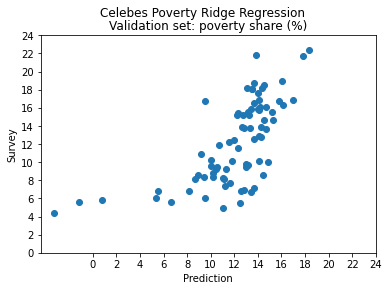

In [91]:
plt.scatter(data_result['y_prediction_ridge'], data_result['y_true'])
plt.ylabel('Survey')
plt.xlabel('Prediction')
plt.xticks(np.arange(0, 25,2)) 
plt.yticks(np.arange(0, 25,2))
plt.suptitle("Celebes Poverty Ridge Regression")
plt.title('Validation set: poverty share (%)')
txt=""
plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=12)

Text(0.5, -0.1, '')

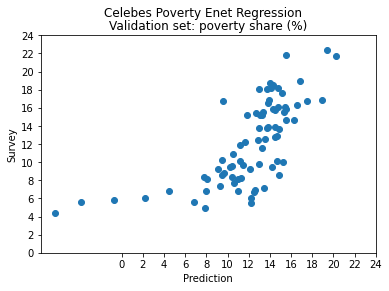

In [92]:
plt.scatter(data_result['y_prediction_enet'], data_result['y_true'])
plt.ylabel('Survey')
plt.xlabel('Prediction')
plt.xticks(np.arange(0, 25,2)) 
plt.yticks(np.arange(0, 25,2)) 
plt.suptitle("Celebes Poverty Enet Regression")
plt.title('Validation set: poverty share (%)')
txt=""
plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=12)

In [93]:
merged_data['pov_prediction_ridge']=best_ridge.predict(merged_data[feat])
merged_data['pov_prediction_enet']=best_enet.predict(merged_data[feat])

In [94]:
merged_data.head()

,IDKEC,GMM_bin,yj_mean_w,GRID_SAT_JPG,FEATURE_000,FEATURE_001,FEATURE_002,FEATURE_003,FEATURE_004,FEATURE_005,...,FEATURE_506,FEATURE_507,FEATURE_508,FEATURE_509,FEATURE_510,FEATURE_511,IDKAB,pov_prediction_ridge,pov_prediction_enet,pov_prediction_svr
0,7104080,0,-0.411780,CNN_DIMG_IND_2015_LS_256_3840_000001_REV.jpg,1.483518,-0.549518,-0.618008,0.134535,-0.665146,-0.536729,...,-0.571589,-0.252379,-0.021947,-0.469171,-0.542241,-0.251967,7104,12.565957,14.655454,10.749299
1,7104080,3,2.316555,CNN_DIMG_IND_2015_LS_256_3840_000002_REV.jpg,2.838306,0.430732,-0.618008,-0.504173,-0.665146,-0.536729,...,-0.571589,1.162027,1.007501,-0.196767,-0.341298,-0.126327,7104,8.269123,3.728547,10.706081
2,7104060,0,-0.411780,CNN_DIMG_IND_2015_LS_256_3840_000003_REV.jpg,1.483518,-0.549518,-0.618008,0.134535,-0.665146,-0.536729,...,-0.571589,-0.252379,-0.021947,-0.469171,-0.542241,-0.251967,7104,12.565957,14.655454,10.749299
3,7104070,0,-0.411780,CNN_DIMG_IND_2015_LS_256_3840_000004_REV.jpg,-0.494105,1.132504,-0.618008,0.529057,-0.560871,-0.536729,...,-0.571589,-0.051411,-0.579124,-0.469171,0.513522,0.170990,7104,12.330680,9.754757,10.725440
4,7104070,0,-0.411780,CNN_DIMG_IND_2015_LS_256_3840_000005_REV.jpg,2.260132,1.686836,-0.618008,-0.504173,-0.610025,-0.536729,...,-0.571589,-0.461053,0.140711,-0.469171,-0.174309,0.520053,7104,13.796300,11.498326,10.729930


In [95]:
merged_data[['pov_prediction_ridge','pov_prediction_enet']].describe()

,pov_prediction_ridge,pov_prediction_enet
count,12690.000000,12690.000000
mean,13.456740,13.494745
std,4.532645,6.859813
min,-6.006341,-23.545923
25%,10.794343,9.460158
50%,13.773853,13.778422
75%,16.428301,17.967926
max,30.558378,40.352354


In [96]:
merged_data[['GRID_SAT_JPG','pov_prediction_ridge','pov_prediction_enet']].to_csv('Result/prediction_.csv',sep=';')